In [51]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import VFDstuff as VFD
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from copy import copy as cp
import matplotlib.path as mpltPath

In [52]:
%matplotlib notebook
fontsize = 25
color = 'k'
linewidth = 4
markersize = 10

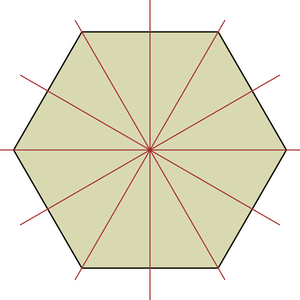

dedge 1.875


<IPython.core.display.Javascript object>


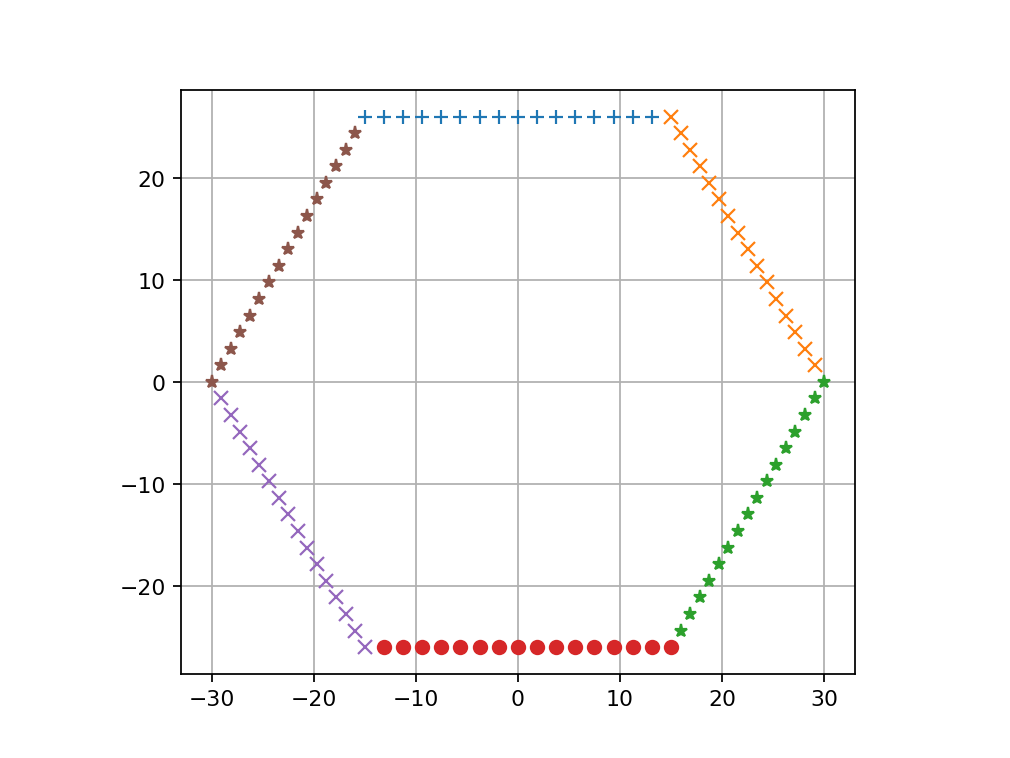

In [53]:
L = 30
npts = 16
npts_total = npts*6

# Make the top edge
angle = 30*np.pi/180
y0 =L*np.cos(angle)
x_edge0 = np.linspace(-L/2,L/2,npts+1); #print(len(x_edge0))
x_edge0 = x_edge0[0:-1]; #print(len(x_edge0))
dedge = x_edge0[1]-x_edge0[0]; print('dedge',dedge)
y_edge0 = np.linspace(y0,y0,npts)
edge0 = np.array([x_edge0,y_edge0]); #print(np.shape(edge0))

fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edge0[0,:],edge0[1,:],'+')
plt.grid(True)

# Make the other edges
angle = 60*np.pi/180
rotation_matrix = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]]); #print(rotation_matrix)
edge1 = np.matmul(rotation_matrix,edge0)
plt.plot(edge1[0,:],edge1[1,:],'x')
edge2 = np.matmul(rotation_matrix,edge1)
plt.plot(edge2[0,:],edge2[1,:],'*')
edge3 = np.matmul(rotation_matrix,edge2)
plt.plot(edge3[0,:],edge3[1,:],'o')
edge4 = np.matmul(rotation_matrix,edge3)
plt.plot(edge4[0,:],edge4[1,:],'x')
edge5 = np.matmul(rotation_matrix,edge4)
plt.plot(edge5[0,:],edge5[1,:],'*')

In [54]:
# Units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'

# Times
tmax = AssignQuantity(.5,time_unit)

# Setting ice parameters
sigma0 = 0.2
print('sigma0 = ',sigma0)

# The far-field supersaturation
sigmaI_far_field = 0.3

# Temperature and pressure
Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Converting to the desired pressure unit
Pressure.ito(pressure_unit)
print('Pressure = ', Pressure)
print('Temperature = ',Temp)

# Checking on the plausibility of this growth rate
nu_kin = VFD.get_nu_kin(Temp,AssignQuantity)
print('g_ice should be smaller than sigmaI_far_field x nu_kin ...')
print('nu_kin = ', nu_kin)
print('sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

dx = dy = AssignQuantity(dedge,distance_unit)
dx2 = dx**2
dy2 = dy**2

Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Compute diffusion coefficient of water through air at this temperature
# This is using trends from engineering toolbox, with the log-log correction
D = VFD.getDofTP(Temp,Pressure,AssignQuantity); print('loglog method says D = ', D)

# Getting a suitable time step
dt = (dx2+dy2)/D/10; print('dt = ', dt)

# Computing effective diffusion coefficents - which should be dimensionless
Dxeff = D*dt/dx2; print('Dxeff = ', Dxeff)
Deff = Dxeff

# Growth rate
g_ice = AssignQuantity(2,'micrometer/second')

# Calculating the Neumann condition at the vapor/ice boundary (starting with ice density)
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')

# kappa
kappa = rho_ice*g_ice*R*Temp/(Mvap*dy); kappa.ito(pressure_unit+'/'+time_unit)

# Neumann
uneumann = kappa*dt
uneumann_mag = uneumann.magnitude

sigma0 =  0.2
Pressure =  50 pascal
Temperature =  240 kelvin
g_ice should be smaller than sigmaI_far_field x nu_kin ...
nu_kin =  39.341788071548116 micrometer / second
sigmaI_far_field x nu_kin =  11.802536421464435 micrometer / second
D0 =  21.893732126411837
loglog method says D =  34908.31943863489 micrometer ** 2 / microsecond
dt =  2.0142046689930718e-05 microsecond
Dxeff =  0.2 dimensionless


In [55]:
# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)

udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


<IPython.core.display.Javascript object>


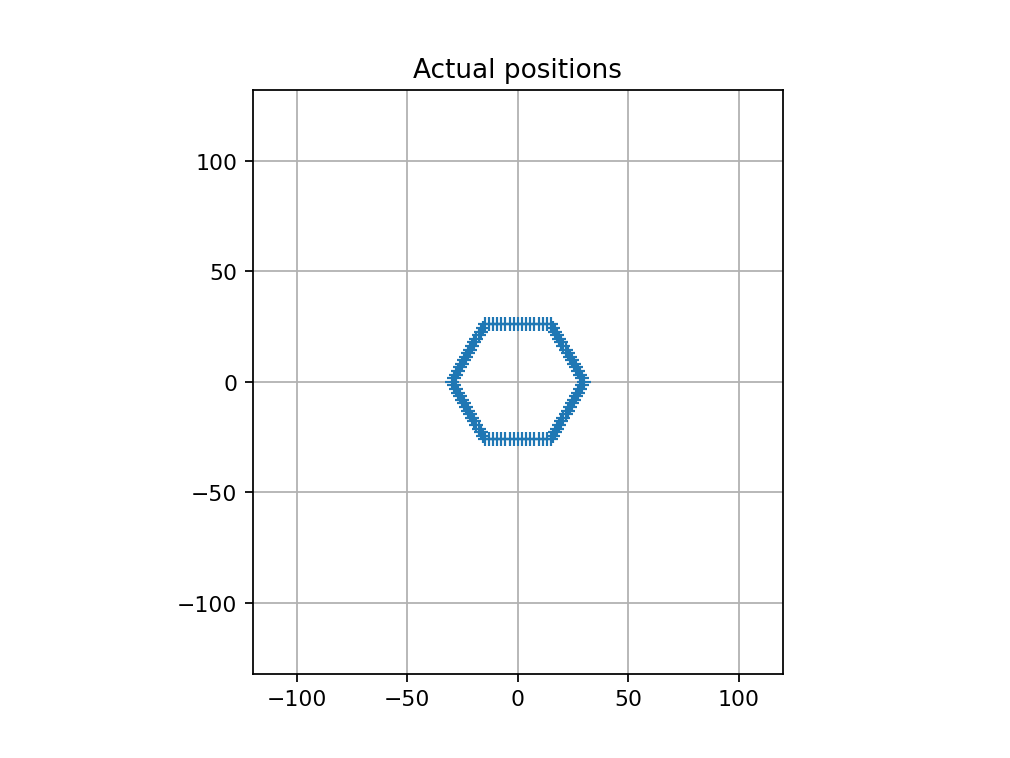

Text(0.5, 1.0, 'Actual positions')

In [56]:
edges = np.hstack([edge0,edge1,edge2,edge3,edge4,edge5])
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edges[0,:],edges[1,:],'+')
plt.grid(True)
Lbox_x = L*4
Lbox_y = Lbox_x*1.1
plt.xlim(-Lbox_x,Lbox_x)
plt.ylim(-Lbox_y,Lbox_y)
plt.title('Actual positions')

In [57]:
xarray = np.arange(-Lbox_x,Lbox_x+dedge,dedge)
yarray = np.arange(-Lbox_y,Lbox_y+dedge,dedge)
ygrid,xgrid = np.meshgrid(yarray,xarray)
nx,ny = np.shape(xgrid)
print(nx,ny)

129 142


In [58]:
def position_to_index(x,L,dx):
    index = np.rint((x+L)/dx).astype(int)
    return(index)

def index_to_position(index,L,dx):
    position = index*dx - L
    return(position)

[[-1.50000000e+01 -1.31250000e+01 -1.12500000e+01 -9.37500000e+00
  -7.50000000e+00 -5.62500000e+00 -3.75000000e+00 -1.87500000e+00
   0.00000000e+00  1.87500000e+00  3.75000000e+00  5.62500000e+00
   7.50000000e+00  9.37500000e+00  1.12500000e+01  1.31250000e+01
   1.50000000e+01  1.59375000e+01  1.68750000e+01  1.78125000e+01
   1.87500000e+01  1.96875000e+01  2.06250000e+01  2.15625000e+01
   2.25000000e+01  2.34375000e+01  2.43750000e+01  2.53125000e+01
   2.62500000e+01  2.71875000e+01  2.81250000e+01  2.90625000e+01
   3.00000000e+01  2.90625000e+01  2.81250000e+01  2.71875000e+01
   2.62500000e+01  2.53125000e+01  2.43750000e+01  2.34375000e+01
   2.25000000e+01  2.15625000e+01  2.06250000e+01  1.96875000e+01
   1.87500000e+01  1.78125000e+01  1.68750000e+01  1.59375000e+01
   1.50000000e+01  1.31250000e+01  1.12500000e+01  9.37500000e+00
   7.50000000e+00  5.62500000e+00  3.75000000e+00  1.87500000e+00
   6.97156831e-15 -1.87500000e+00 -3.75000000e+00 -5.62500000e+00
  -7.50000

<IPython.core.display.Javascript object>


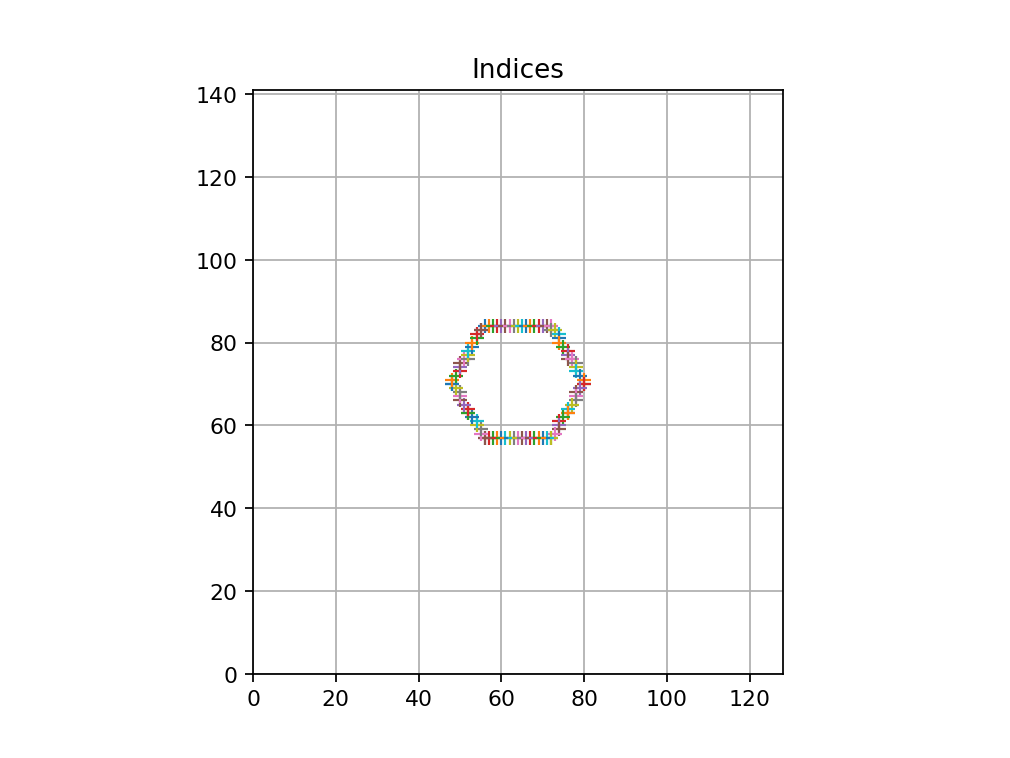

0
128
0
141


Text(0.5, 1.0, 'Indices')

In [59]:
# Indices of the boundary points
ixedges = position_to_index(edges[0,:],Lbox_x,dedge); print(edges,ixedges)
iyedges = position_to_index(edges[1,:],Lbox_y,dedge); print(iyedges)
iedges = np.vstack((ixedges,iyedges))
fig, ax = plt.subplots()
ax.set_aspect('equal')
for i in range(npts_total):
    plt.plot(iedges[0,i],iedges[1,i],'+')
iLbox_xmin = position_to_index(-Lbox_x,Lbox_x,dedge); print(iLbox_xmin)
iLbox_xmax = position_to_index( Lbox_x,Lbox_x,dedge); print(iLbox_xmax)
iLbox_ymin = position_to_index(-Lbox_y,Lbox_y,dedge); print(iLbox_ymin)
iLbox_ymax = position_to_index( Lbox_y,Lbox_y,dedge); print(iLbox_ymax)
plt.xlim(iLbox_xmin,iLbox_xmax)
plt.ylim(iLbox_ymin,iLbox_ymax)
plt.grid(True)
plt.title('Indices')


In [60]:
# set that keeps track of what elements have been added
def removedups(mylist):
    
    seen = set()
    no_dups = []
    for lst in mylist.T:

        # convert to hashable type
        current = tuple(lst)

        # If element not in seen, add it to both
        if current not in seen:
            no_dups.append(lst)
            seen.add(current)
        else:
            print('not keeping', current)
            
    npts_unique, dummy = np.shape(no_dups); #print(npts_unique)
    ixedges_unique = []
    iyedges_unique = []

    for i in range(npts_unique):
        ixedges_unique.append(no_dups[i][0])
        iyedges_unique.append(no_dups[i][1])

    no_dups = np.vstack((ixedges_unique,iyedges_unique))

    return no_dups, npts_unique

def removedups2(mylist1,mylist2):
    
    seen = set()
    for lst in mylist2.T:
        current = tuple(lst)
        seen.add(current)
    
    no_dups = []
    for lst in mylist1.T:

        # convert to hashable type
        current = tuple(lst)

        # If element not in seen, add it to both
        if current not in seen:
            no_dups.append(lst)
        else:
            print('not keeping', current)
            
    npts_unique, dummy = np.shape(no_dups); #print(npts_unique)
    ixedges_unique = []
    iyedges_unique = []

    for i in range(npts_unique):
        ixedges_unique.append(no_dups[i][0])
        iyedges_unique.append(no_dups[i][1])

    no_dups = np.vstack((ixedges_unique,iyedges_unique))

    return no_dups, npts_unique

In [61]:
iedges_unique, npts_unique = removedups(iedges)
print(np.shape(iedges))
print(np.shape(iedges_unique))

not keeping (80, 70)
not keeping (76, 63)
not keeping (72, 57)
not keeping (56, 57)
not keeping (52, 63)
not keeping (48, 70)
not keeping (55, 83)
(2, 96)
(2, 89)


not keeping (52, 76)
not keeping (57, 84)
not keeping (58, 84)
not keeping (59, 84)
not keeping (60, 84)
not keeping (61, 84)
not keeping (62, 84)
not keeping (63, 84)
not keeping (64, 84)
not keeping (65, 84)
not keeping (66, 84)
not keeping (67, 84)
not keeping (68, 84)
not keeping (69, 84)
not keeping (70, 84)
not keeping (71, 84)
not keeping (72, 83)
not keeping (76, 76)


<IPython.core.display.Javascript object>


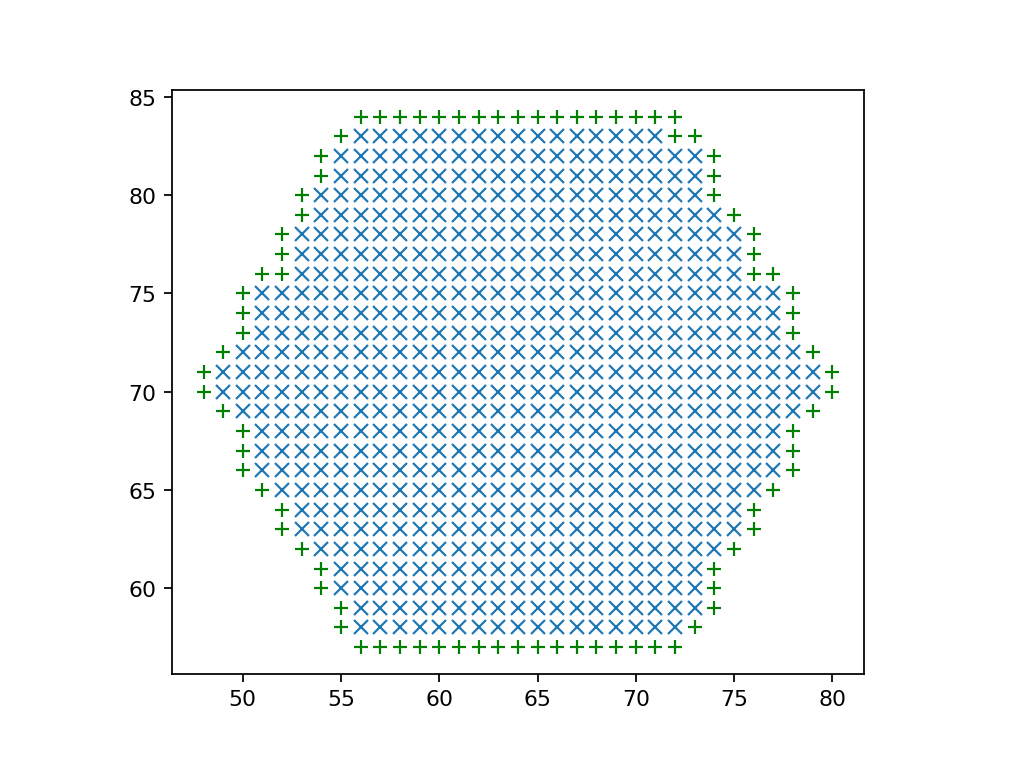

In [62]:
# Getting indices of pixels inside the crystal
iedges_unique_float = iedges_unique.astype(float)
polygon = iedges_unique_float.T
path = mpltPath.Path(polygon); #print(path)
ix_inside = []
iy_inside = []
for ix in range(nx):
    for iy in range(ny):
        inside = path.contains_points([[ix,iy]])
        if inside:
            ix_inside.append(ix)
            iy_inside.append(iy)
i_inside = np.vstack((ix_inside,iy_inside))
i_inside_unique, n_inside_unique = removedups2(i_inside,iedges_unique)
ix_inside_unique = i_inside_unique[0,:]
iy_inside_unique = i_inside_unique[1,:]

fig, ax = plt.subplots()
ax.set_aspect('equal')
for i in range(npts_unique):
    plt.plot(iedges_unique[0,i],iedges_unique[1,i],'+g')
plt.plot(ix_inside_unique,iy_inside_unique,'x')

<IPython.core.display.Javascript object>


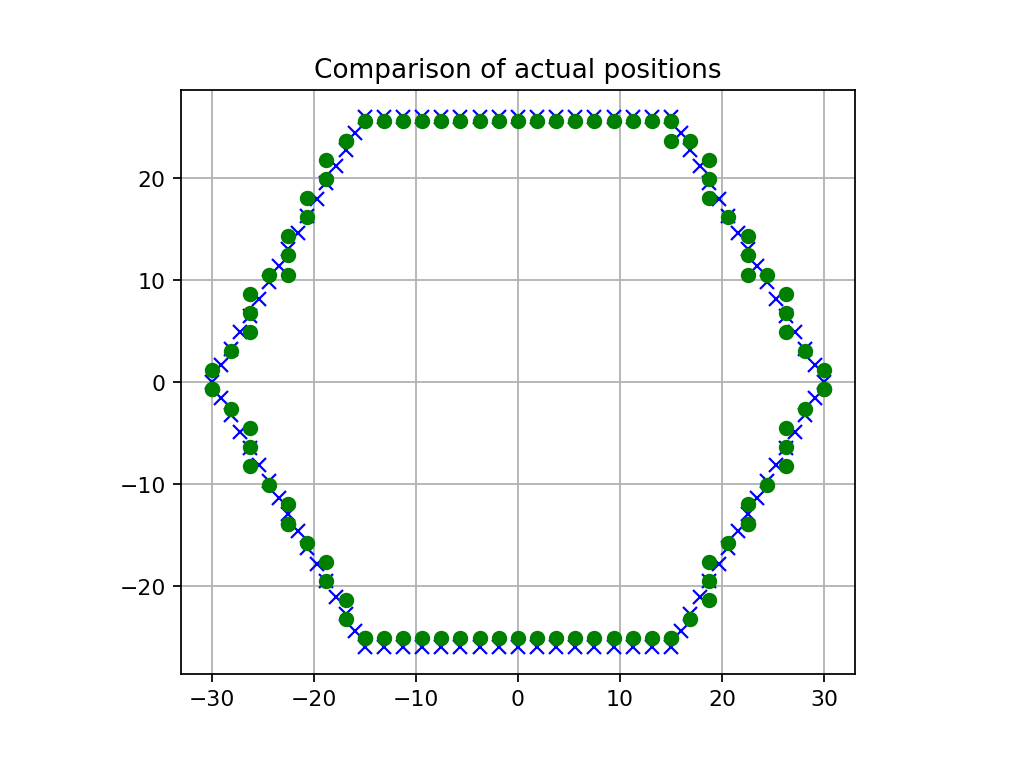

Text(0.5, 1.0, 'Comparison of actual positions')

In [63]:
xedges_again = index_to_position(ixedges,Lbox_x,dedge)
yedges_again = index_to_position(iyedges,Lbox_y,dedge)
edges_again = np.vstack((xedges_again,yedges_again))
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edges[0,:],edges[1,:],'bx')
plt.plot(edges_again[0,:],edges_again[1,:],'go')
plt.grid(True)
plt.title('Comparison of actual positions')

In [64]:
# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)

udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


In [65]:
def propagate_hexagon(u0,udirichlet,uneumann,Deff,iedges,npts_total,i_inside_unique,n_inside_unique):

    # Initialize starting values
    un = np.zeros(np.shape(u0))

    # Diffusion throughout
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Deff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Deff )
    
    # Dirichlet
    un[[0,-1],:] = udirichlet
    un[:,[0,-1]] = udirichlet
    
    # Neumann
    for i in range(npts_total):
        un[iedges[0,i],iedges[1,i]] -= uneumann
        
    # Inside the crystal (this isn't really necessary)
#     for i in range(n_inside_unique):
#         un[i_inside_unique[0,i],i_inside_unique[1,i]] = udirichlet
    
    return(un)

In [101]:
tmax = AssignQuantity(2,time_unit)
ntimes = int(tmax/dt)
print('Integrating steps = ', ntimes)
print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above

un = np.zeros(np.shape(xgrid))
for i in range(ntimes):
    un = propagate_hexagon(\
        un,udirichlet.magnitude,uneumann.magnitude,Deff.magnitude,\
        iedges, npts_total,\
        i_inside_unique,n_inside_unique)

Integrating steps =  99294
Integrating out to  1.9999843840299807 microsecond


<IPython.core.display.Javascript object>


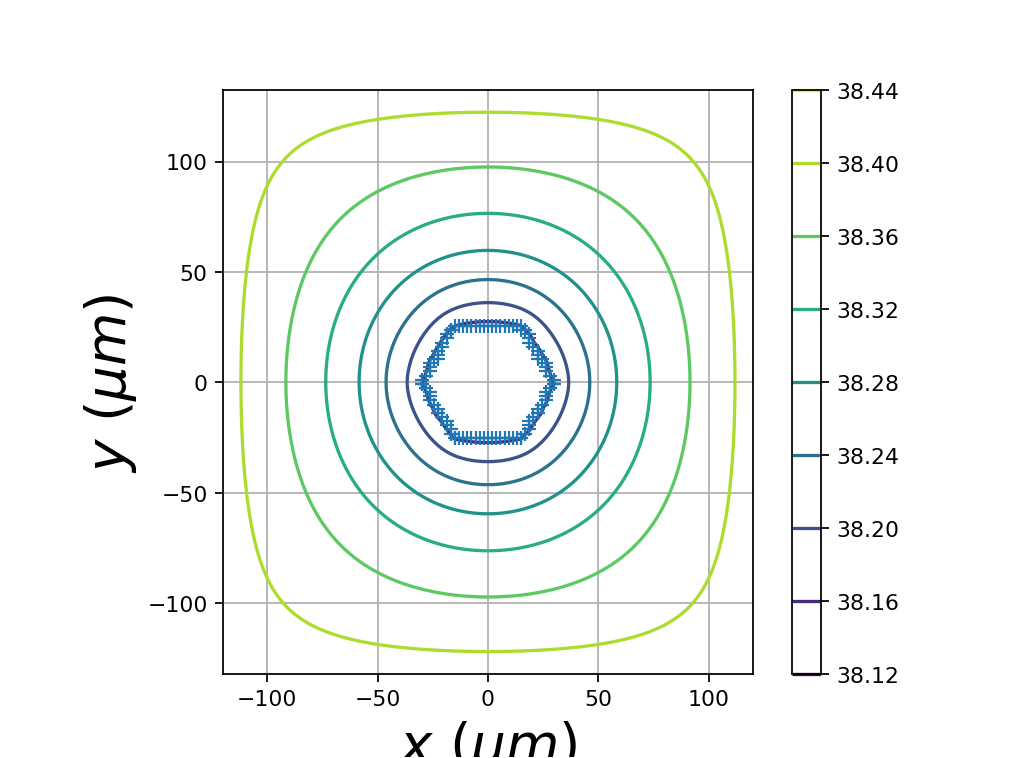

In [102]:
# Graph as contour plot
fig,ax = plt.subplots()
ax.set_aspect('equal')
CS = ax.contour(xarray,yarray,un.T)
ax.set_xlabel(r'$x$ ($\mu m$)', fontsize=fontsize)
ax.set_ylabel(r'$y$ ($\mu m$)', fontsize=fontsize)
plt.grid(True)
fig.colorbar(CS)
plt.plot(edges_again[0,:],edges_again[1,:],'+')

<IPython.core.display.Javascript object>


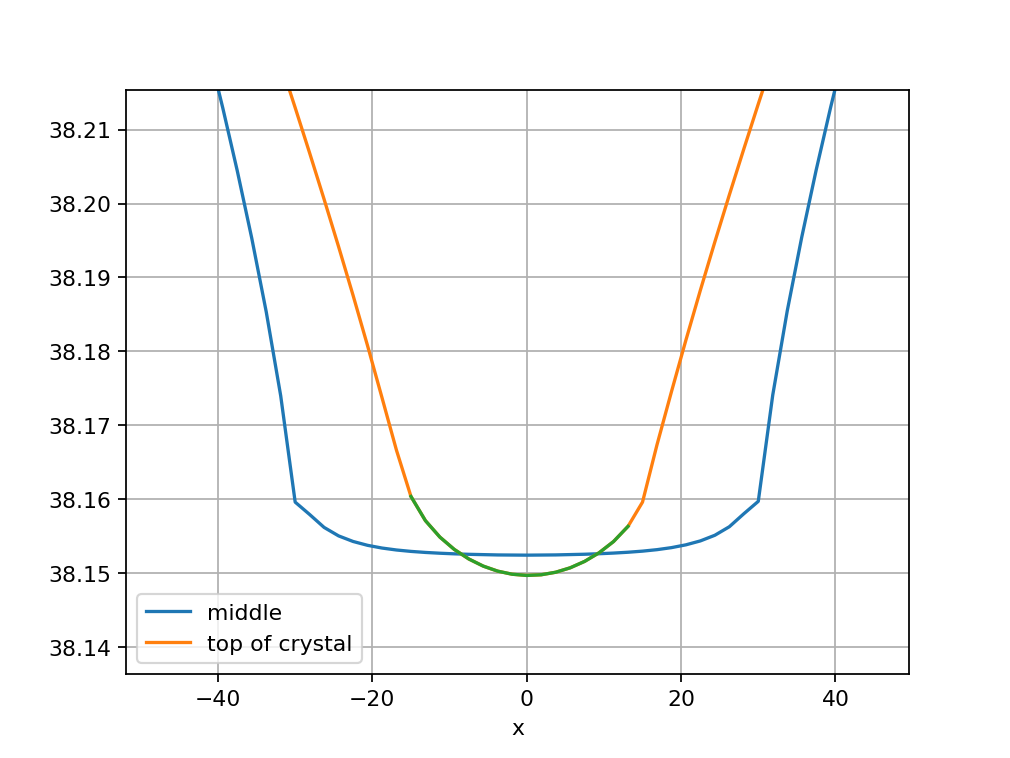

70
84
[56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]


In [103]:
plt.figure()

iymid = position_to_index(0,Lbox_y,dedge); print(iymid)
plt.plot(xarray,un[:,iymid],label='middle')

iytop = position_to_index(y0,Lbox_y,dedge); print(iytop)
plt.plot(xarray,un[:,iytop],label='top of crystal')

ix_edge0 = position_to_index(x_edge0,Lbox_x,dedge); print(ix_edge0)
plt.plot(x_edge0,un[ix_edge0,iytop])

plt.grid(True)
plt.xlabel('x')
plt.legend()